<font size="10">Learning Transformations to Period-Doubling Normal Forms with the Centre Manifold Theorem</font>

<font size="4">In this notebook we train an autoencoder neural network architecture to identify a change of variable from the nonlinear mapping of Golden and Ydstie (1988, Systems and Control Letters). We combine centre manifold and normal form theory to target a transformation to a system in three variables $(y_1,y_2,y_3)$, for which $y_1$ represents the dynamics on the centre manifold and $(y_2,y_3)$ are on the stable manifold. We focus our computations about a point of (supercritical) period-doubling bifurcation in the map and so the dynamics of $y_1$ are governed by the normal form of this bifurcation: $g_{\mathrm{pd}}(y,\nu) = - y - y(\nu - y^2)$. The stable components $(y_2,y_3)$ are governed by a linear matrix equation for which the matrix is given by the Jordan normal form of the linearization of the stable components at the bifurcation point.</font>

<font size="4">At the end of this notebook and in the accompanying MATLAB script make_plots.m we use this local conjugacy to produce a local bifurcation diagram in the $(\mu,x_3)$ plane for the period-doubling bifurcation.</font>

<font size="4">This code was written by Jason J. Bramburger and accompanies the work in Section 6.3 of the book <i>Data-Driven Methods for Dynamic Systems</i>. We use Tensorflow 2.0 to build the neural network, which is imported as tf.

In [185]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [303]:
# Sample random points in the (x,mu) domain
N = 10000 # number of samples
xn = np.zeros((N,4)) # Augmented to include the 3D state x_n and 1D parameter mu
xnp1 = np.zeros((N,4))

# Generate random points
for n in range(1,N):
    xn[n,0] = 0.4*np.random.rand(1) - 0.2
    xn[n,1] = 0.4*np.random.rand(1) - 0.2
    xn[n,2] = 0.4*np.random.rand(1) - 0.2
    xn[n,3] = 0.4*np.random.rand(1) - 0.2
    
# Forward iterate of the adaptive control map
xnp1[:,0] = xn[:,1]
xnp1[:,1] = np.multiply(xn[:,3]*0.1 + 0.25, xn[:,0] + 1) + np.multiply(xn[:,1] + 1, xn[:,2] - xn[:,3]*0.1 - 0.25)
xnp1[:,2] = xn[:,2] - np.multiply(xn[:,3]*0.1 + 0.25, np.multiply(xn[:,0] + 1, xn[:,1] + 1)) - np.multiply(xn[:,2] - xn[:,3]*0.1 - 0.25, np.multiply(xn[:,1] + 1, xn[:,1] + 1))
xnp1[:,3] = xn[:,3]

In [305]:
# Conjugacy neural network architecture

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Conjugacy(Model):
  def __init__(self,
                 width = 100,
                 size_x = 4,
                 size_y = 4,
                 activation = 'selu',
                 numblksIn = 1,
                 numblksOut = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
    super(Conjugacy, self).__init__()
    self.width = width 
    self.size_x = size_x
    self.size_y = size_y
    self.activation = activation
    self.numblksIn = numblksIn
    self.numblksOut = numblksOut
    self.l1reg = l1reg
    self.l2reg = l2reg
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
    
    # Encoder function 
    self.encoder = tf.keras.Sequential()
    
    for n in range(self.numblksIn): #adding more layers
        self.encoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    # Final layer to go to logistic map variables
    self.encoder.add(layers.Dense(self.size_y, activation=self.activation, 
                                  kernel_initializer=self.initializer,
                                  kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                  bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))

    # Decoder function
    self.decoder = tf.keras.Sequential()
    
    for n in range(self.numblksOut): #adding more layers
        self.decoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    # Final layer to go to tent map variables 
    self.decoder.add(tf.keras.layers.Dense(self.size_x, activation= self.activation, 
                                           kernel_initializer=self.initializer, 
                                           kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                           bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    
  def call(self, x):
    
    # Apply encoder/conjugacy
    encoded = self.encoder(x)
    
    # Build forward iterates under normal form
    ynp1 = -encoded[:,0] - tf.multiply(encoded[:,3],encoded[:,0]) + tf.multiply(tf.square(encoded[:,0]),encoded[:,0]) # Period-doubling normal form
    ynp2 = 0.5*(tf.math.cos(0.7227)*encoded[:,1] + tf.math.sin(0.7227)*encoded[:,2])
    ynp3 = 0.5*(-tf.math.sin(0.7227)*encoded[:,1] + tf.math.cos(0.7227)*encoded[:,2])
    munp1 = encoded[:,3] # parameter step
    encoded_p1 = tf.stack([ynp1, ynp2, ynp3, munp1], axis = -1)
    decoded = self.decoder(encoded_p1)
    
    # Encoder/Decoder loss
    x_recon = self.decoder(encoded)
    self.add_loss(tf.reduce_mean(tf.math.square(x - x_recon)))
    
    # f = rho of g of eta loss
    xnp1_1 = x[:,1]
    xnp1_2 = tf.multiply(x[:,3]*0.1 + 0.25, x[:,0] + 1) + tf.multiply(x[:,1] + 1, x[:,2] - x[:,3]*0.1 - 0.25)
    xnp1_3 = x[:,2] - tf.multiply(x[:,3]*0.1 + 0.25, tf.multiply(x[:,0] + 1, x[:,1] + 1)) - tf.multiply(x[:,2] - x[:,3]*0.1 - 0.25, tf.multiply(x[:,1] + 1, x[:,1] + 1))
    xnp1_4 = x[:,3]
    xnp1 = tf.stack([xnp1_1, xnp1_2, xnp1_3, xnp1_4], axis = -1)
    self.add_loss(tf.reduce_mean(tf.math.square(decoded - xnp1)))
    
    # Normal form loss
    xnp1_encoded = self.encoder(xnp1)
    self.add_loss(tf.reduce_mean(tf.math.square(encoded_p1 - xnp1_encoded)))
    
    # Enforce bifurcation point
    self.add_loss(tf.reduce_mean(tf.math.square(self.encoder(0*x))))

    return decoded

In [311]:
width = 200 # width of each NN layer
size_x = 4 # number of variables in the adaptive control map (states + parameters)
size_y = 4 # number of variables in the normal form (states + parameters)
activation = 'selu' # nonlinear activation function at each NN layer
learning_rate = 0.00005
numblks_in = 5 # number of layers for the encoder NN
numblks_out = 5 # number of layers for the decoder NN

In [312]:
conjugacy = Conjugacy(width, size_x, size_y, activation, numblks_in, numblks_out)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 200)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
conjugacy.compile(optimizer=optimizer, loss = 'mse') 

conjugacy.fit(xn, xnp1, callbacks = [callback], epochs = 5000)

Epoch 1/5000
313/313 [==============================] - 3s 4ms/step - loss: 0.1414
Epoch 2/5000
313/313 [==============================] - 1s 4ms/step - loss: 0.0141
Epoch 3/5000
313/313 [==============================] - 1s 4ms/step - loss: 0.0082
Epoch 4/5000
313/313 [==============================] - 1s 4ms/step - loss: 0.0059
Epoch 5/5000
313/313 [==============================] - 1s 4ms/step - loss: 0.0047
Epoch 6/5000
313/313 [==============================] - 1s 4ms/step - loss: 0.0039
Epoch 7/5000
313/313 [==============================] - 1s 4ms/step - loss: 0.0034
Epoch 8/5000
313/313 [==============================] - 1s 4ms/step - loss: 0.0031
Epoch 9/5000
313/313 [==============================] - 1s 5ms/step - loss: 0.0027
Epoch 10/5000
313/313 [==============================] - 1s 4ms/step - loss: 0.0026
Epoch 11/5000
313/313 [==============================] - 1s 4ms/step - loss: 0.0025
Epoch 12/5000
313/313 [==============================] - 1s 4ms/step - loss: 0.0022
E

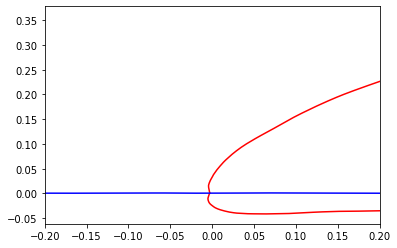

In [313]:
# Check where fixed points in the normal form go to
flip_1 = np.zeros((10000,4)) # first point of the 2-cycle in normal form
flip_2 = np.zeros((10000,4)) # second point of the 2-cycle in normal form
fixed_pt = np.zeros((20000,4)) # trivial fixed point in normal form
for n in range(10000):
    fixed_pt[n,3] = -0.2+0.2*n/10000
    fixed_pt[10000+n,3] = 0.2*n/10000 
    flip_1[n,3] = 0.2*n/10000
    flip_2[n,3] = flip_1[n,3]
    flip_1[n,0] = np.sqrt(flip_1[n,3])
    flip_2[n,0] = -np.sqrt(flip_2[n,3])  
    
# Decode normal form fixed points    
flip_x1 = conjugacy.decoder(flip_1)
flip_x2 = conjugacy.decoder(flip_2)
fixed_pt_x = conjugacy.decoder(fixed_pt)

# Plot results
plt.plot(flip_x1[:,3],flip_x1[:,2],'r')
plt.plot(flip_x2[:,3],flip_x2[:,2],'r')
plt.plot(fixed_pt_x[:,3],fixed_pt_x[:,2],'b')
plt.xlim(-0.2,0.2);

# Print results
#print(fixed_pt_x)

In [316]:
# Save network config
#!mkdir -p saved_conjugacy_networks
conjugacy.save('saved_conjugacy_networks/period_doubling')

INFO:tensorflow:Assets written to: saved_conjugacy_networks/period_doubling/assets


In [315]:
# Output to MATLAB
import scipy.io

# Save data as .mat file
scipy.io.savemat('period_doubling.mat', dict(flip_x1 = flip_x1.numpy(), flip_x2 = flip_x2.numpy(), fixed_pt_x = fixed_pt_x.numpy()))
# This data is used in the MATLAB script make_plots.m to plot the bifurcation diagrams